In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

# **Matrix Multiplication**

**Dimensionality Reduction:** If the goal is to reduce the dimensionality, the output space will have fewer dimensions than the input space.

**Dimensionality Expansion:** Conversely, for dimensionality expansion, the output space will have more dimensions.

In [ ]:
# Input layer
input_layer = Input(shape=(64,))  # Example input with 64 dimensions

# Projection layer for dimensionality reduction
projection_layer = Dense(32, use_bias=False)(input_layer)  # Reduces dimensionality to 32

# Projection layer for dimensionality expansion
expansion_layer = Dense(128, use_bias=False)(input_layer)  # Expands dimensionality to 128

# Create model for demonstration
model = Model(inputs=input_layer, outputs=[projection_layer, expansion_layer])

# Summarize model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │          2,048 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │          8,192 │ input_layer[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,240 (40.00 KB)

 Trainable params: 10,240 (40.00 KB)

 Non-trainable params: 0 (0.00 B)

# **Embedding Layers as Projection Layers**

In Natural Language Processing (NLP), embedding layers are a specific type of projection layer used to transform sparse, categorical data (like words) into a dense, continuous vector space. This representation often reveals semantic relationships between words and is more efficient for processing by downstream layers.

In [ ]:
from tensorflow.keras.layers import Embedding

# Example embedding layer
embedding_layer = Embedding(input_dim=10000, output_dim=64)  # Projecting 10,000 words to 64-dimensional vectors

# Input for text sequences
text_input = Input(shape=(None,))

# Apply embedding layer
embedded_text = embedding_layer(text_input)

# Summarize part of the model
embedding_model = Model(inputs=text_input, outputs=embedded_text)
embedding_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 64)            │         640,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 640,000 (2.44 MB)

 Trainable params: 640,000 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

# **Word2Vec From Scratch**

Based on
https://medium.com/@enozeren/word2vec-from-scratch-with-python-1bba88d9f221

# **Our Small Corpus**

In [ ]:
dog_cat_words = ['dog', 'cat', 'pet', 'house', 'animal', 'sleep', 'play']
family_words = ['girl', 'boy', 'father', 'mother', 'family', 'house', 'marriage']
king_queen_words = ['crown', 'queen', 'king', 'empire', 'country', 'rule', 'castle']

In [ ]:
import random

dog_cat_text = ''
family_text = ''
king_queen_text = ''

for _ in range(10_000):
    random.shuffle(dog_cat_words)
    dog_cat_text = dog_cat_text + ' ' + ' '.join(dog_cat_words)
    random.shuffle(family_words)
    family_text = family_text + ' ' + ' '.join(family_words)
    random.shuffle(king_queen_words)
    king_queen_text = king_queen_text + ' ' + ' '.join(king_queen_words)

small_corpus = dog_cat_text + ' ' + family_text + ' ' + king_queen_text
print(small_corpus)

file_name = "small_corpus.txt"
with open(file_name, 'w') as file:
    file.write(small_corpus)

 animal house sleep cat play pet dog sleep pet cat house dog play animal house dog animal cat play pet sleep cat dog animal play house sleep pet cat sleep dog house animal pet play dog house sleep play animal cat pet sleep cat house animal dog pet play play dog cat house sleep animal pet play animal dog cat house pet sleep animal play dog pet house cat sleep play house dog pet animal cat sleep cat dog play sleep animal pet house play sleep pet animal house cat dog animal dog play sleep cat house pet play cat sleep house pet animal dog pet play animal sleep cat dog house cat house play pet sleep dog animal sleep pet dog cat animal play house pet house dog animal sleep play cat cat pet sleep house dog animal play cat pet play animal dog sleep house cat sleep dog house pet animal play dog play pet cat sleep animal house dog house animal cat pet sleep play house dog cat pet play animal sleep play dog animal sleep house pet cat pet dog animal sleep play cat house animal sleep cat house play

# **Importing our corpus and preprocessing**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import random

from collections import deque
import matplotlib.pyplot as plt

import json

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
file_path = 'small_corpus.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

In [ ]:
def extract_unique_words(text):
    # Lowercase and tokenize the text
    text = text.lower()
    words = word_tokenize(text)

    # Remove punctuation
    words = [word for word in words if word.isalpha()]

    # Count the number of words and unique words
    print("# of words in the text: ", len(words))

    print("First 10 words: ", words[:10])

    unique_words = sorted(set(words))
    print("# of unqiue words in the text: ", len(unique_words))

    return unique_words

In [ ]:
unique_words = extract_unique_words(text)

# of words in the text:  210000
First 10 words:  ['animal', 'house', 'sleep', 'cat', 'play', 'pet', 'dog', 'sleep', 'pet', 'cat']
# of unqiue words in the text:  20


In [ ]:
def generate_cbows(text, window_size):
    # Lowercase and tokenize the text
    text = text.lower()
    words = word_tokenize(text)

    # Remove punctuation
    words = [word for word in words if word.isalpha()]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Create CBOW pairs with a given window size
    cbows = []
    print(words)
    for i, target_word in enumerate(words):
        context_words = words[max(0, i - window_size):i] + words[i + 1:i + window_size + 1]
        if len(context_words) == window_size * 2:
            cbows.append((context_words, target_word))
    return cbows

In [ ]:
# Create cbows
cbows = generate_cbows(text, window_size=3)

# Display the results
for context_words, target_word in cbows[:3]:
    print(f'Context Words: {context_words}, Target Word: {target_word}')

['animal', 'house', 'sleep', 'cat', 'play', 'pet', 'dog', 'sleep', 'pet', 'cat', 'house', 'dog', 'play', 'animal', 'house', 'dog', 'animal', 'cat', 'play', 'pet', 'sleep', 'cat', 'dog', 'animal', 'play', 'house', 'sleep', 'pet', 'cat', 'sleep', 'dog', 'house', 'animal', 'pet', 'play', 'dog', 'house', 'sleep', 'play', 'animal', 'cat', 'pet', 'sleep', 'cat', 'house', 'animal', 'dog', 'pet', 'play', 'play', 'dog', 'cat', 'house', 'sleep', 'animal', 'pet', 'play', 'animal', 'dog', 'cat', 'house', 'pet', 'sleep', 'animal', 'play', 'dog', 'pet', 'house', 'cat', 'sleep', 'play', 'house', 'dog', 'pet', 'animal', 'cat', 'sleep', 'cat', 'dog', 'play', 'sleep', 'animal', 'pet', 'house', 'play', 'sleep', 'pet', 'animal', 'house', 'cat', 'dog', 'animal', 'dog', 'play', 'sleep', 'cat', 'house', 'pet', 'play', 'cat', 'sleep', 'house', 'pet', 'animal', 'dog', 'pet', 'play', 'animal', 'sleep', 'cat', 'dog', 'house', 'cat', 'house', 'play', 'pet', 'sleep', 'dog', 'animal', 'sleep', 'pet', 'dog', 'cat', 

In [ ]:
len(cbows)

209994

In [ ]:
def one_hot_encoding(word, unique_words):
  encoding = []
  for w in unique_words:
    if word == w:
      encoding.append(1)
    else:
      encoding.append(0)
  return torch.tensor(encoding, dtype=torch.float32)

In [ ]:
# Create one-hot encodings for each word
one_hot_encodings = {word: one_hot_encoding(word, unique_words) for word in unique_words}
one_hot_encodings['king']

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.])

In [ ]:
cbow_vector_pairs = []
for context_words, target_word in cbows:
  context_vectors = []
  for word in context_words:
    context_vectors.append(one_hot_encodings[word])
  cbow_vector_pairs.append((context_vectors, one_hot_encodings[target_word]))

In [ ]:
cbow_vector_pairs[0][0] # contains the 6 context word one-hot encoded vectors

[tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.])]

In [ ]:
cbow_vector_pairs[0][1] # contains the center word as one-hot encoded vector

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [ ]:
# Sum the context vectors to get a single context vector
cbow_vector_pairs = [(torch.sum(torch.stack(context_vectors), dim=0), target_vector) for context_vectors, target_vector in cbow_vector_pairs]

# **Pytorch Model**

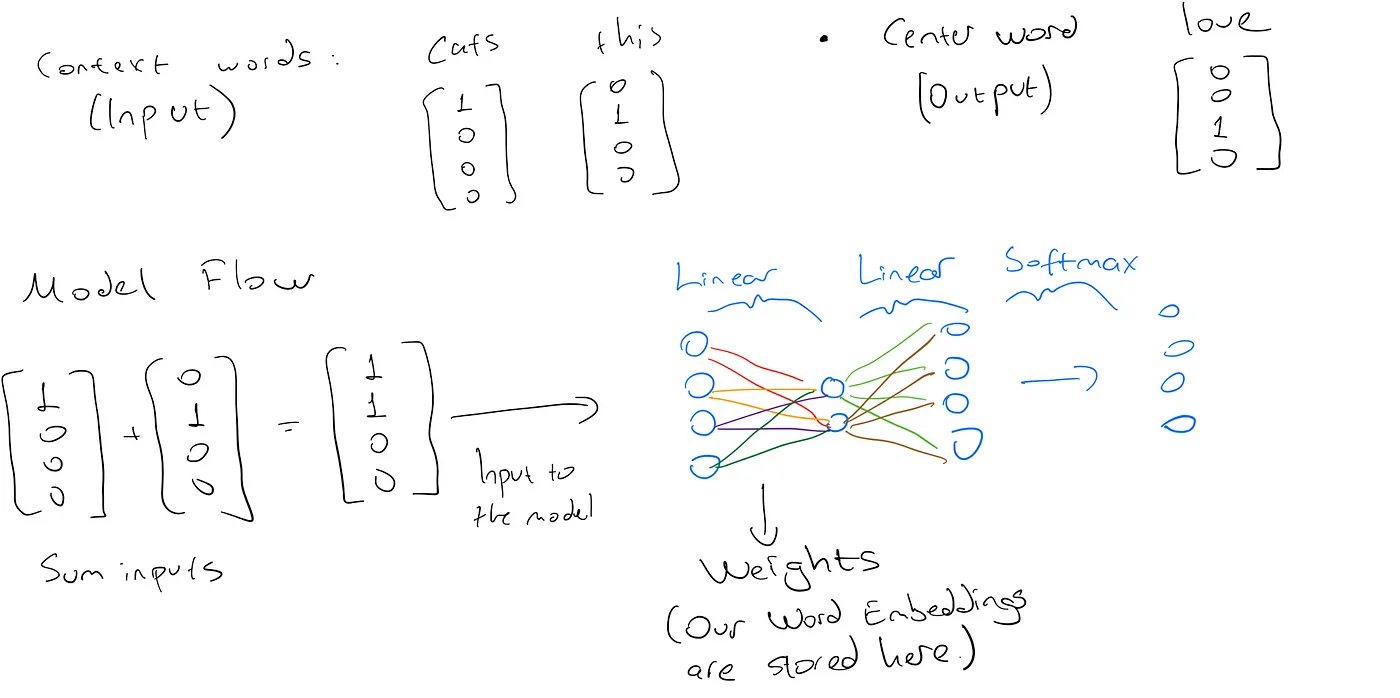

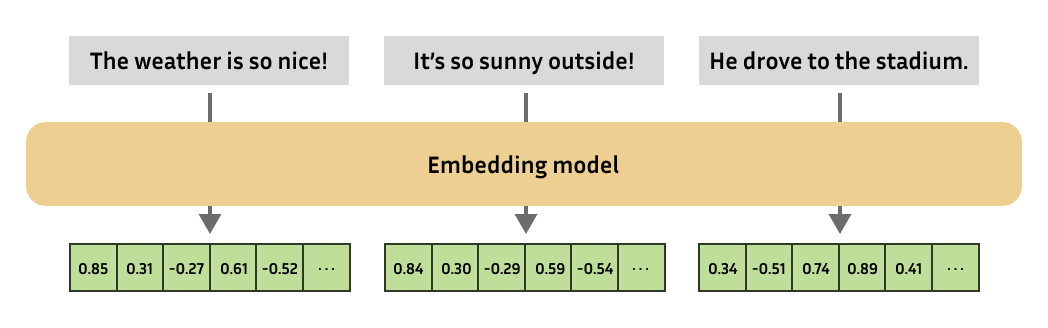

In [ ]:
class NaiveWord2Vec(nn.Module):

    def __init__(self, VOCAB_SIZE, VECTOR_DIM) -> None:
        super().__init__()

        self.vocab_size = VOCAB_SIZE
        self.vector_dim = VECTOR_DIM
        self.W1 = nn.Parameter(data=torch.randn(self.vocab_size, self.vector_dim), requires_grad=True) # Word Vectors
        self.W2 = nn.Parameter(data=torch.randn(self.vector_dim, self.vocab_size), requires_grad=True)

    def forward(self, X) -> torch.tensor:
        X = X @ self.W1
        X = X @ self.W2

        return X

In [ ]:
VOCAB_SIZE = len(unique_words)
VECTOR_DIM = 2

# **Converting the dataset to PyTorch Dataset**

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.inputs = [item[0] for item in data]
        self.outputs = [item[1] for item in data]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_sample = self.inputs[idx]
        output_sample = self.outputs[idx]
        return input_sample, output_sample

In [ ]:
# Shuffle pairs before training
cbow_vector_pairs = random.sample(cbow_vector_pairs, len(cbow_vector_pairs))

# Train and Val split
split_index = int(len(cbow_vector_pairs) * 0.90)

# Split the data into training and test sets
train_dataset = CustomDataset(cbow_vector_pairs[:split_index])
test_dataset = CustomDataset(cbow_vector_pairs[split_index:])

# Set batch size
batch_size = 64  # You can adjust this based on your requirements

# Create DataLoader for training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **Train Model**

In [ ]:
model = NaiveWord2Vec(VOCAB_SIZE, VECTOR_DIM)

In [ ]:
def train_model(model, train_dataloader, validation_dataloader, epochs, learning_rate, verbose=False):

    # Create the loss function
    loss_fn = nn.CrossEntropyLoss()
    # Create the optimizer object
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    # Log the loss values
    train_set_loss_log = []
    validation_set_loss_log = []

    for epoch in range(epochs):
        if verbose: print("Epoch: ", epoch)
        # Training mode on
        model.train()
        total_train_loss = 0.0
        num_train_batches = 0

        for inputs_batch, outputs_batch in train_dataloader:

            y_train_logits = model(inputs_batch)
            train_loss = loss_fn(y_train_logits, outputs_batch)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            total_train_loss += train_loss.item()
            num_train_batches += 1

        # Calculate average training loss for the epoch
        average_train_loss = total_train_loss / num_train_batches
        train_set_loss_log.append(average_train_loss)

        # Eval mode on
        model.eval()
        total_validation_loss = 0.0
        num_validation_batches = 0

        with torch.inference_mode():
            for inputs_batch, outputs_batch in validation_dataloader:
                # Evaluate the validation loss
                y_val_logits = model(inputs_batch)
                validation_loss = loss_fn(y_val_logits, outputs_batch)

                total_validation_loss += validation_loss.item()
                num_validation_batches += 1

        # Calculate average validation loss for the epoch
        average_validation_loss = total_validation_loss / num_validation_batches
        validation_set_loss_log.append(average_validation_loss)

        if verbose: print("Train Loss: ", average_train_loss, "|||", "Validation Loss: ", average_validation_loss)


    return model, train_set_loss_log, validation_set_loss_log

In [ ]:
model, train_set_loss_log, validation_set_loss_log = train_model(model, train_dataloader, validation_dataloader,
                                                                 epochs=3, learning_rate=0.01, verbose=True)

Epoch:  0
Train Loss:  2.0361387644495283 ||| Validation Loss:  1.860874389080291
Epoch:  1
Train Loss:  1.8560244098013128 ||| Validation Loss:  1.8568964051620576
Epoch:  2
Train Loss:  1.851872635396171 ||| Validation Loss:  1.852308934220427


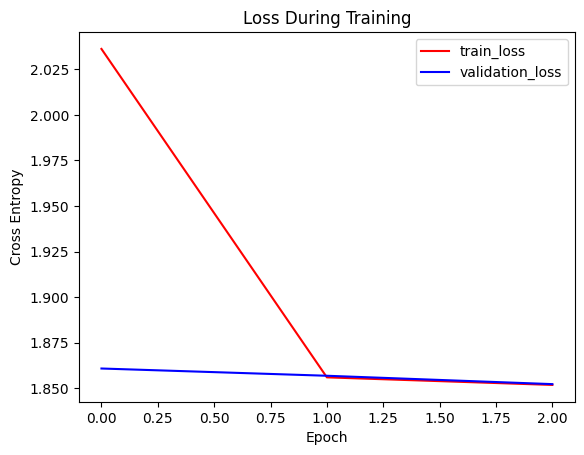

In [ ]:
plt.plot(train_set_loss_log, color='red', label='train_loss')
plt.plot(validation_set_loss_log, color='blue', label='validation_loss')

plt.title("Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")
plt.legend()
plt.show()

In [ ]:
params = list(model.parameters())
params

[Parameter containing:
 tensor([[-5.8411e-02, -9.2940e-01],
         [-9.2505e-01,  1.5683e-01],
         [ 1.5097e-01,  2.5961e-01],
         [-7.4421e-01, -3.8913e+00],
         [ 6.1757e-02,  1.6073e-01],
         [ 1.6744e-01,  1.6184e-01],
         [-1.5195e-01, -8.8361e-01],
         [ 3.1202e-01,  4.7209e-02],
         [-9.7109e-01,  1.3974e-01],
         [-1.0546e+00,  1.3720e-01],
         [-1.0017e+00,  2.3655e-01],
         [ 1.0830e+00,  6.8851e-01],
         [ 8.9631e-01,  2.8209e+00],
         [-9.2495e-01,  1.6316e-01],
         [-2.1384e+00,  3.1444e-01],
         [-2.4931e-01, -7.6318e-01],
         [-1.4940e-01, -1.0329e+00],
         [ 1.7485e-01,  2.5612e-03],
         [ 3.6808e+00, -3.2412e-01],
         [-2.0669e-01, -8.6919e-01]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0283, -1.2395,  1.5362,  0.5540,  1.5074,  1.4926,  0.0671,  1.4742,
          -1.2612, -1.2346, -1.2580, -1.8039,  1.6124, -1.2711, -1.1259,  0.2409,
           0.0818,  1.4392, 

In [ ]:
# Word Vectors
params = list(model.parameters())
word_vectors = params[0].detach()

In [ ]:
# Create a dictionary with the same order mapping
word_dict = {word: vector for word, vector in zip(unique_words, word_vectors)}

In [ ]:
word_dict

{'animal': tensor([-0.0584, -0.9294]),
 'boy': tensor([-0.9251,  0.1568]),
 'castle': tensor([0.1510, 0.2596]),
 'cat': tensor([-0.7442, -3.8913]),
 'country': tensor([0.0618, 0.1607]),
 'crown': tensor([0.1674, 0.1618]),
 'dog': tensor([-0.1519, -0.8836]),
 'empire': tensor([0.3120, 0.0472]),
 'family': tensor([-0.9711,  0.1397]),
 'father': tensor([-1.0546,  0.1372]),
 'girl': tensor([-1.0017,  0.2366]),
 'house': tensor([1.0830, 0.6885]),
 'king': tensor([0.8963, 2.8209]),
 'marriage': tensor([-0.9250,  0.1632]),
 'mother': tensor([-2.1384,  0.3144]),
 'pet': tensor([-0.2493, -0.7632]),
 'play': tensor([-0.1494, -1.0329]),
 'queen': tensor([0.1749, 0.0026]),
 'rule': tensor([ 3.6808, -0.3241]),
 'sleep': tensor([-0.2067, -0.8692])}

# **Evaluating the Word Vectors**

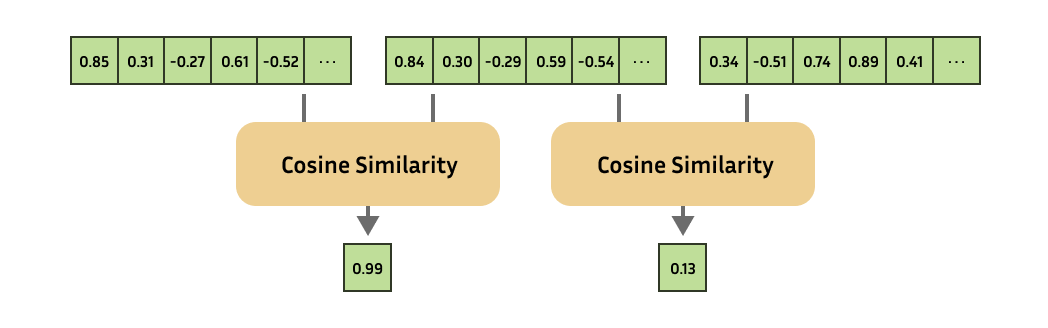

In [ ]:
def cosine_similarity(v1, v2):
    return (v1 @ v2) / (torch.norm(v1) * torch.norm(v2))

def most_similar(word, word_dict, top_k=5):
    if word not in word_dict:
        raise ValueError(f"{word} not found in the word dictionary.")

    query_vector = word_dict[word]

    # Calculate cosine similarity with all other words in the dictionary
    similarities = {}
    for other_word, other_vector in word_dict.items():
        if other_word != word:
            similarity = cosine_similarity(query_vector, other_vector)
            similarities[other_word] = similarity

    # Sort the words by similarity in descending order
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Get the top-k most similar words
    top_similar_words = sorted_similarities[:top_k]

    return top_similar_words

In [ ]:
word_dict['dog']

tensor([-0.1519, -0.8836])

In [ ]:
most_similar('dog', word_dict)

[('cat', tensor(0.9998)),
 ('play', tensor(0.9996)),
 ('sleep', tensor(0.9980)),
 ('animal', tensor(0.9942)),
 ('pet', tensor(0.9894))]

In [ ]:
most_similar('father', word_dict)

[('family', tensor(0.9999)),
 ('mother', tensor(0.9999)),
 ('boy', tensor(0.9993)),
 ('marriage', tensor(0.9990)),
 ('girl', tensor(0.9947))]

In [ ]:
most_similar('queen', word_dict)

[('rule', tensor(0.9948)),
 ('empire', tensor(0.9908)),
 ('house', tensor(0.8517)),
 ('crown', tensor(0.7291)),
 ('castle', tensor(0.5153))]

In [ ]:
cosine_similarity(word_dict['father'], word_dict['mother'])

tensor(0.9999)

In [ ]:
cosine_similarity(word_dict['family'], word_dict['empire'])

tensor(-0.9574)

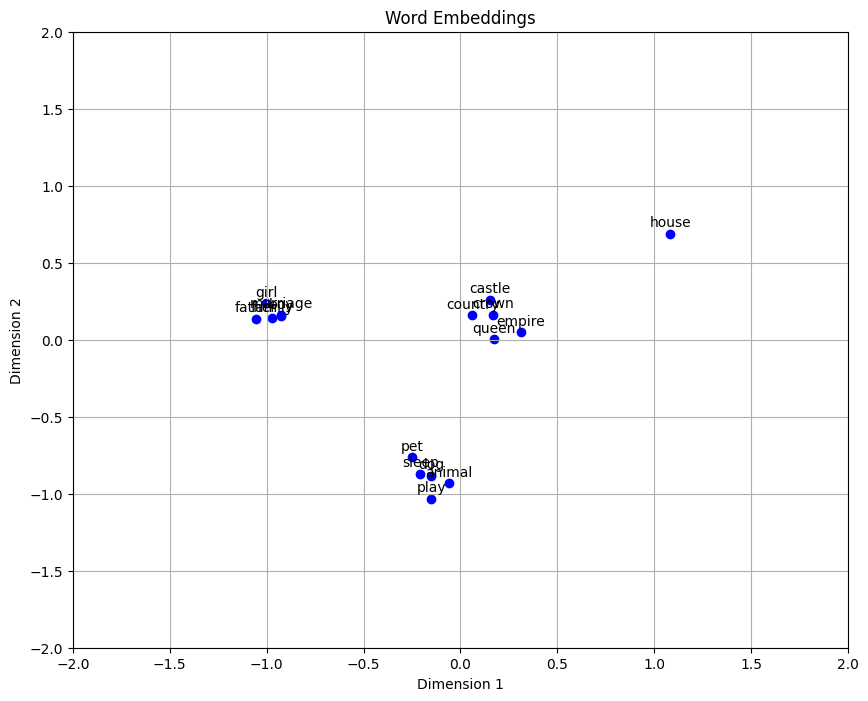

In [ ]:
x_coords, y_coords = zip(*[word_dict[word].numpy() for word in list(word_dict.keys())])

plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, marker='o', color='blue')

for i, word in enumerate(list(word_dict.keys())):
    plt.annotate(word, (x_coords[i], y_coords[i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()

# **Export Vectors**

In [ ]:
# Specify the file path where you want to save the JSON file
file_path = 'pretrained_word_vectors.json'

# Convert torch.Tensor objects to lists
word_vec_for_export = word_dict.copy()
for key, value in word_vec_for_export.items():
    if isinstance(value, torch.Tensor):
        word_vec_for_export[key] = value.tolist()

# Use json.dump to write the modified dictionary to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(word_vec_for_export, json_file, indent=2)

print(f'Dictionary has been exported to {file_path}')

Dictionary has been exported to pretrained_word_vectors.json
